In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import KNNImputer
import torch

from model import *

In [3]:
sns.set(style='darkgrid')
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.seed(42)

# Load Data

In [39]:
# Load mentee survey data
survey_results = pd.read_csv('./data/survey_results.csv')
questions = survey_results.iloc[0]
survey_results = survey_results.iloc[2:]
id_questions = ['Q1', 'Q2']
numeric_questions = ['Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_1', 'Q19_1', 'Q19_2', 'Q19_3', 'Q19_4', 'Q19_5', 'Q19_6', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q21_1', 'Q21_2', 'Q21_3', 'Q21_4', 'Q21_5', 'Q22_1', 'Q22_2', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28_1', 'Q29', 'Q30', 'Q31', 'Q32']
# Eliminate empty names
for col in id_questions:
    survey_results = survey_results[survey_results[col].notna()]
# Clean strings
def clean(x):
    if pd.isnull(x):
        return x
    else:
        return int(''.join(s for s in x if s.isdigit()))
survey_results[numeric_questions] = survey_results[numeric_questions].applymap(clean)
# Fill missing results
knn = KNNImputer(n_neighbors=5)
survey_results[numeric_questions] = knn.fit_transform(survey_results[numeric_questions])
survey_results[numeric_questions] = survey_results[numeric_questions].astype(int)
# Standardize
survey_results[numeric_questions] = preprocessing.scale(survey_results[numeric_questions], axis=0)
# Finalize
survey_ids = np.array(survey_results[id_questions].applymap(lambda x: x.lower()))
survey_ids = np.array([' '.join(x) for x in survey_ids])
survey_ids = survey_ids.flatten()
survey_results = np.array(survey_results[numeric_questions])
# Remove duplicates by ids (might want to take last occurrence)
_, first_occurrences = np.unique(survey_ids, return_index=True)
mentee_survey_ids, mentee_survey_results = survey_ids[first_occurrences], survey_results[first_occurrences]

# Load mentor survey data
survey_results = pd.read_csv('./data/survey_results_mentors.csv')
questions = survey_results.iloc[0]
survey_results = survey_results.iloc[2:]
id_questions = ['email address']
# categorical_questions = ['Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33']
numeric_questions = ['Q3_1', 'Q3_2', 'Q3_3', 'Q3_4', 'Q3_5', 'Q3_6', 'Q3_7', 'Q3_8', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_1', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q19_1', 'Q19_2', 'Q19_3', 'Q19_4', 'Q20_1', 'Q20_2', 'Q20_3', 'Q20_4', 'Q20_5', 'Q21_1', 'Q21_2', 'Q22', 'Q23', 'Q24', 'Q25']
# Eliminate empty names
for col in id_questions:
    survey_results = survey_results[survey_results[col].notna()]
# Clean strings
def clean(x):
    if pd.isnull(x):
        return x
    else:
        return int(''.join(s for s in x if s.isdigit()))
survey_results[numeric_questions] = survey_results[numeric_questions].applymap(clean)
# Fill missing results
knn = KNNImputer(n_neighbors=5)
survey_results[numeric_questions] = knn.fit_transform(survey_results[numeric_questions])
survey_results[numeric_questions] = survey_results[numeric_questions].astype(int)
# Standardize
survey_results[numeric_questions] = preprocessing.scale(survey_results[numeric_questions], axis=0)
# Finalize
survey_ids = np.array(survey_results[id_questions].applymap(lambda x: x.lower()))
survey_ids = np.array([' '.join(x) for x in survey_ids])
survey_ids = survey_ids.flatten()
survey_results = np.array(survey_results[numeric_questions])
# Remove duplicates by ids (might want to take last occurrence)
_, first_occurrences = np.unique(survey_ids, return_index=True)
mentor_survey_ids, mentor_survey_results = survey_ids[first_occurrences], survey_results[first_occurrences]

# Load match data
match_results = pd.read_csv('./data/matches.csv')
mentor_cols = [' Mentor Email']
mentee_cols = ['Mentee First Name', 'Mentee Last Name']
match_results_mentor = np.array(match_results[mentor_cols].applymap(lambda x: x.lower()))
match_results_mentor = np.array([' '.join(x) for x in match_results_mentor])
match_results_mentee = np.array(match_results[mentee_cols].applymap(lambda x: x.lower()))
match_results_mentee = np.array([' '.join(x) for x in match_results_mentee])
match_results = np.stack([match_results_mentee, match_results_mentor], axis=1)

# Take and filter to intersection of mentees
mentee_intersection = np.intersect1d(match_results[:, 0], mentee_survey_ids)
survey_idx = [n in mentee_intersection for n in mentee_survey_ids]
mentee_survey_ids = mentee_survey_ids[survey_idx]
mentee_survey_results = mentee_survey_results[survey_idx]
match_idx = [n in mentee_intersection for n in match_results[:, 0]]
match_results = match_results[match_idx, :]

# Take and filter to intersection of mentors
mentor_intersection = np.intersect1d(match_results[:, 1], mentor_survey_ids)
survey_idx = [n in mentor_intersection for n in mentor_survey_ids]
mentor_survey_ids = mentor_survey_ids[survey_idx]
mentor_survey_results = mentor_survey_results[survey_idx]
match_idx = [n in mentor_intersection for n in match_results[:, 1]]
match_results = match_results[match_idx, :]

# Take and filter to intersection of mentees (again, since mentor filtering could exclude a few)
mentee_intersection = np.intersect1d(match_results[:, 0], mentee_survey_ids)
survey_idx = [n in mentee_intersection for n in mentee_survey_ids]
mentee_survey_ids = mentee_survey_ids[survey_idx]
mentee_survey_results = mentee_survey_results[survey_idx]

# Unique mentors
mentors, match_results[:, 1] = np.unique(match_results[:, 1], return_inverse=True)
mentor_survey_ids = np.array([np.argwhere(n == mentors)[0] for n in mentor_survey_ids]).flatten()
# Unique mentees
mentees, match_results[:, 0] = np.unique(match_results[:, 0], return_inverse=True)
mentee_survey_ids = np.array([np.argwhere(n == mentees)[0] for n in mentee_survey_ids]).flatten()

# Formulate vars
matches = match_results.astype(int)
matches_outcome = np.ones(len(matches)).astype(float)  # Presence data
mentee_features = mentee_survey_results.astype(float)
mentee_features_ids = mentee_survey_ids
mentor_features = mentor_survey_results.astype(float)
mentor_features_ids = mentor_survey_ids
# mentees
# mentors

In [21]:
# Train-Test
train_frac = .7
mentees_train_idx = range(int(train_frac * len(mentees)))
mentees_test_idx = list(set(range(len(mentees))) - set(mentees_train_idx))
mentors_train_idx = range(int(train_frac * len(mentors)))
mentors_test_idx = list(set(range(len(mentors))) - set(mentors_train_idx))

# Reserve full
mentee_features_full = mentee_features
mentor_features_full = mentor_features
mentee_features_ids_full = mentee_features_ids
mentor_features_ids_full = mentor_features_ids
matches_full = matches
matches_outcome_full = matches_outcome

sort_idx = np.argsort(mentee_features_ids)  # TODO, Further shuffle matches
mentee_features, mentee_features_test = mentee_features[sort_idx][mentees_train_idx], mentee_features[sort_idx][mentees_test_idx]
mentee_features_ids, mentee_features_ids_test = mentee_features_ids[sort_idx][mentees_train_idx], mentee_features_ids[sort_idx][mentees_test_idx]

sort_idx = np.argsort(mentor_features_ids)  # TODO, Further shuffle matches
mentor_features, mentor_features_test = mentor_features[sort_idx][mentors_train_idx], mentor_features[sort_idx][mentors_test_idx]
mentor_features_ids, mentor_features_ids_test = mentor_features_ids[sort_idx][mentors_train_idx], mentor_features_ids[sort_idx][mentors_test_idx]

idx = [(mentee in mentee_features_ids and mentor in mentor_features_ids) for mentee, mentor in matches]
tidx = [(mentee in mentee_features_ids_test and mentor in mentor_features_ids_test) for mentee, mentor in matches]
midx = list(set(range(len(matches))) - set(idx) - set(tidx))
matches, matches_test, matches_mixed = matches[idx], matches[tidx], matches[midx]
matches_outcome, matches_outcome_test, matches_outcome_mixed = matches_outcome[idx], matches_outcome[tidx], matches_outcome[midx]
# Finalize dim variables
num_mentors = len(mentors_train_idx)
num_mentees = len(mentees_train_idx)
num_matches = len(matches)
num_mentees_features = mentee_features.shape[1]
num_mentors_features = mentor_features.shape[1]
num_mentors_test = len(mentors_test_idx)
num_mentees_test = len(mentors_test_idx)
num_matches_test = len(matches_test)

# Implement fake negatives (optional)
fake_percentage = .5
fake_num = int(fake_percentage * num_matches / (1 - fake_percentage))
fake_mentees = np.random.choice(range(num_mentees), fake_num, replace=True)
fake_mentors = np.random.choice(range(num_mentors), fake_num, replace=True)
fake_matches = np.stack((fake_mentees, fake_mentors), axis=1)
fake_outcome = np.zeros(fake_num)
# Append
matches = np.concatenate((matches, fake_matches), axis=0)
matches_outcome = np.concatenate((matches_outcome, fake_outcome), axis=0)
num_matches = len(matches)

# Cast to type
matches = torch.Tensor(matches.astype(float)).int()
matches_test = torch.Tensor(matches_test.astype(float)).int()
matches_mixed = torch.Tensor(matches_mixed.astype(float)).int()
matches_outcome = torch.Tensor(matches_outcome).float()
matches_outcome_test = torch.Tensor(matches_outcome_test).float()
matches_outcome_mixed = torch.Tensor(matches_outcome_mixed).float()
mentee_features = torch.Tensor(mentee_features).float()
mentee_features_test = torch.Tensor(mentee_features_test).float()
mentee_features_full = torch.Tensor(mentee_features_full).float()
mentor_features = torch.Tensor(mentor_features).float()
mentor_features_test = torch.Tensor(mentor_features_test).float()
mentor_features_full = torch.Tensor(mentor_features_full).float()

# Adversarial Model

In [22]:
# User Variables
dim_embedding = 10
epochs = 10001
batches = 20
lr = .001
epoch_pd = 2000
batch_size = 64
batches = int(len(matches)/batch_size)

# Generator Model
gen_model = EmbeddingGenerationModel(num_mentees, num_mentors, dim=dim_embedding)
gen_optimizer = torch.optim.AdamW(gen_model.parameters(), lr=lr)
gen_criterion = nn.MSELoss()

# Inference Model
inf_model = EmbeddingInferenceModel(num_features, dim=dim_embedding)
inf_optimizer = torch.optim.AdamW(inf_model.parameters(), lr=lr)
inf_criterion = nn.MSELoss()

# Adversarial Criterion
adv_criterion = nn.MSELoss()

In [23]:
gen_model.train()
inf_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        loss = 0
        
        # Train embeddings
        gen_optimizer.zero_grad()
        gen_idx = np.random.choice(range(len(matches)), batch_size, replace=False)
        gen_input_data = torch.t(matches[gen_idx])
        gen_logits = gen_model(*gen_input_data)
        gen_loss = gen_criterion(gen_logits, matches_outcome[gen_idx])
        gen_loss.backward()
        gen_optimizer.step()
        
        # Train survey features
        inf_optimizer.zero_grad()
        inf_idx = np.unique(matches[gen_idx, 0])
        inf_input_data = mentee_features[inf_idx]
        inf_logits = inf_model(inf_input_data)
        inf_true = gen_model.mentees(torch.Tensor(inf_idx).int()).detach()
        inf_loss = inf_criterion(inf_logits, inf_true)
        inf_loss.backward()
        inf_optimizer.step()
        
        # Adversarial loss
        gen_optimizer.zero_grad()
        inf_optimizer.zero_grad()
        adv_loss = adv_criterion(inf_model(inf_input_data), gen_model.mentees(torch.Tensor(inf_idx).int()))
        adv_loss.backward()
        gen_optimizer.step()
        inf_optimizer.step()
        
    if epoch % epoch_pd == 0:
        print(f'Epoch: {epoch}', end=' \t')
        print(f'Generator Loss: {float(gen_loss)}', end=' \t')
        print(f'Inference Loss: {float(inf_loss)}', end=' \t')
        print(f'Adversarial Loss: {float(adv_loss)}')
gen_model.eval();

Epoch: 0 	Generator Loss: 0.6655675172805786 	Inference Loss: 1.9971427917480469 	Adversarial Loss: 1.9776912927627563
Epoch: 2000 	Generator Loss: 0.0012880854774266481 	Inference Loss: 0.0036372938193380833 	Adversarial Loss: 0.003575975773856044
Epoch: 4000 	Generator Loss: 0.004476433619856834 	Inference Loss: 0.00040145055390894413 	Adversarial Loss: 0.0004027979157399386
Epoch: 6000 	Generator Loss: 1.2623593647731468e-05 	Inference Loss: 9.204450907418504e-05 	Adversarial Loss: 9.196078462991863e-05
Epoch: 8000 	Generator Loss: 0.004153081215918064 	Inference Loss: 3.425210525165312e-05 	Adversarial Loss: 3.210903378203511e-05
Epoch: 10000 	Generator Loss: 0.008077919483184814 	Inference Loss: 2.0747324015246704e-05 	Adversarial Loss: 2.0076477085240185e-05


## Visualization

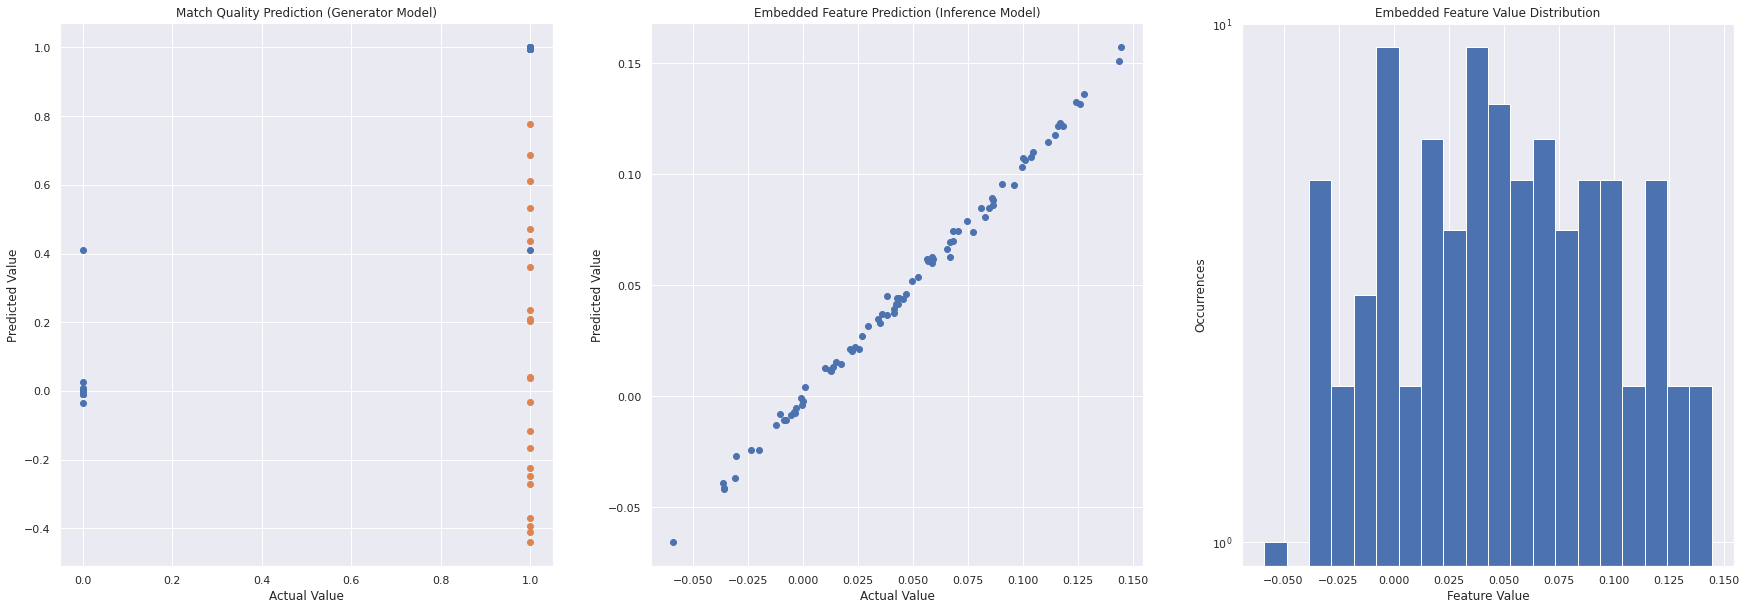

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

# Plot embedding accuracy
plt.sca(axs[0])
predicted = gen_model(*torch.t(matches)).detach().cpu().numpy()
actual = matches_outcome
feat_test = inf_model(mentee_features_test[(matches_test[:, 0] - len(train_idx)).numpy()]).detach().cpu()
predicted_test = gen_model(feat_test, matches_test[:, 1], manual_e=True).detach().cpu().numpy()
actual_test = matches_outcome_test

plt.scatter(actual, predicted)
plt.scatter(actual_test, predicted_test)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Match Quality Prediction (Generator Model)')

# Plot survey features
plt.sca(axs[1])
feature = 0
input_data = mentee_features
predicted = inf_model(input_data).detach().cpu().numpy()
actual = gen_model.mentees(torch.Tensor(range(num_mentees)).int()).detach().cpu().numpy()
predicted, actual = predicted[:, feature], actual[:, feature]

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedded Feature Prediction (Inference Model)')

# Plot histogram of survey values
plt.sca(axs[2])
plt.hist(actual, bins=20)
plt.xlabel('Feature Value')
plt.ylabel('Occurrences')
plt.title('Embedded Feature Value Distribution')
plt.gca().set_yscale('log');